# EhV Quality control

In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from ehv.core import plot_gate_zarr, plot_gate_zarr_channels
from ehv.masking import plot_scip_segmentation

In [4]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
from scip.masking import threshold
from scip.masking import util
from scip.features import texture
import zarr

## SCIP computed features

In [5]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

## Load processed frame

In [114]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/features.parquet").to_pandas()

## No bounding box

In [115]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(131783, 1296)

## Number of identified regions per channel 

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


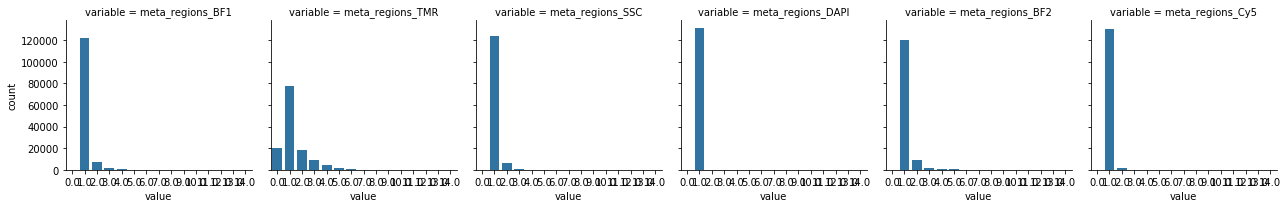

In [116]:
tmp = pandas.melt(df.reset_index(), value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

In [117]:
sel = ((df["meta_regions_BF1"] == 1) & (df["meta_regions_BF2"] == 1))

In [118]:
df = df[sel]
df.shape

(116839, 1296)

## NaN values

In [119]:
# show all NaN columns
df.columns[df.isna().all(axis=0)]

Index([], dtype='object')

### GLCM features

Many NaN values occur for features that have no default value for when no mask is found. This occurs in texture and shape features.

In [9]:
def compute_glcm(r, bbox_channel_index=0, smooth=0.75):
    z = zarr.open(r.meta_path)
    pixels = z[r.meta_zarr_idx].reshape(z.attrs["shape"][r.meta_zarr_idx])
    pixels = numpy.clip(pixels, a_min=0, a_max=4096)

    m = threshold.get_mask(dict(pixels=pixels), main=True, main_channel=bbox_channel_index, smooth=smooth)
    m = util.get_bounding_box(m)
    m = threshold.get_mask(m, main=False, main_channel=bbox_channel_index, smooth=smooth)
    m = util.remove_regions_touching_border(m, bbox_channel_index=bbox_channel_index)
    m = util.apply(m)

    fig, axes = plt.subplots(2, len(pixels), dpi=150, squeeze=False)
    for i, (a, p) in enumerate(zip(m["mask"], pixels)):
        axes[0, i].imshow(a)
        axes[0, i].set_axis_off()
        axes[1, i].imshow(p)
        axes[1, i].set_axis_off()
        
    m = texture.texture_features(m, 4096)
        
    return m, fig

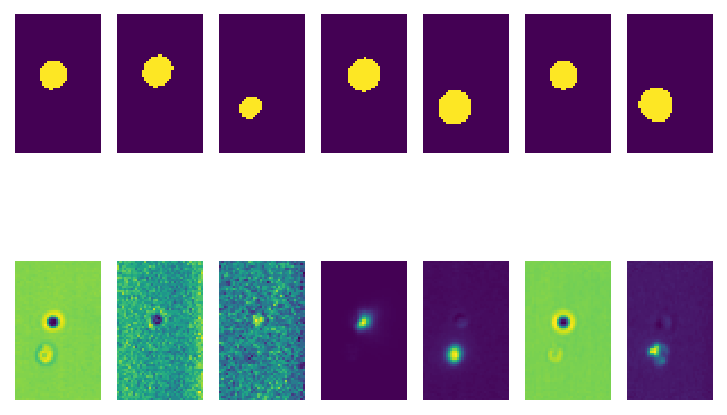

In [10]:
r = df[df.filter(regex="glcm").isna().any(axis=1)].iloc[0]
m, fig = compute_glcm(r, smooth=1.5)

In [11]:
cols = df.filter(regex="glcm").columns[df.filter(regex="glcm").isna().any()]

In [12]:
glcms = pandas.DataFrame(list(map(lambda a: re.match(r"feat_?(?P<comb>combined)?_glcm_(?P<type>[^_]+)_(?P<name>[^_]+)_(?P<dist>[0-9])_(?P<channel>.+)$", a).groupdict(), cols)))

In [13]:
glcms["channel"].unique()

array(['BF1', 'TMR', 'SSC', 'BF2'], dtype=object)

In [14]:
glcms["dist"].value_counts()

5    24
3    20
Name: dist, dtype: int64

In [15]:
glcms.groupby("dist")["type"].value_counts()

dist  type
3     mean    10
      std     10
5     std     13
      mean    11
Name: type, dtype: int64

In [16]:
glcms.groupby("dist")["name"].value_counts()

dist  name         
3     ASM              5
      contrast         4
      correlation      4
      dissimilarity    3
      homogeneity      3
      energy           1
5     correlation      5
      dissimilarity    5
      ASM              4
      contrast         4
      energy           3
      homogeneity      3
Name: name, dtype: int64

In [17]:
glcms.groupby("channel")["name"].value_counts()

channel  name         
BF1      correlation      2
         dissimilarity    2
         energy           2
         homogeneity      2
         ASM              1
BF2      contrast         4
         dissimilarity    4
         homogeneity      4
SSC      ASM              4
         contrast         4
         correlation      3
         dissimilarity    2
TMR      ASM              4
         correlation      4
         energy           2
Name: name, dtype: int64

In [21]:
df["meta_label"].value_counts()

mcp-_psba+    104814
mcp+_psba-      7956
mcp-_psba-      5624
mcp+_psba+      5545
unknown         4959
Name: meta_label, dtype: int64

# Low variance features

In [120]:
v = df.filter(regex="feat").var()

In [121]:
v.isna().sum()

0

In [122]:
low_var = df.filter(regex="feat").columns[df.filter(regex="feat").var() < 0.001]

In [123]:
low_var

Index(['feat_moments_central-0-1_combined',
       'feat_moments_central-1-0_combined', 'feat_moments_hu-0_combined',
       'feat_moments_hu-1_combined', 'feat_moments_hu-2_combined',
       'feat_moments_hu-3_combined', 'feat_moments_hu-4_combined',
       'feat_moments_hu-5_combined', 'feat_moments_hu-6_combined',
       'feat_solidity_BF1',
       ...
       'feat_glcm_mean_ASM_3_Cy5', 'feat_glcm_mean_ASM_5_Cy5',
       'feat_glcm_std_ASM_3_Cy5', 'feat_glcm_std_ASM_5_Cy5',
       'feat_combined_glcm_std_homogeneity_3_Cy5',
       'feat_combined_glcm_std_homogeneity_5_Cy5',
       'feat_combined_glcm_std_energy_3_Cy5',
       'feat_combined_glcm_std_energy_5_Cy5',
       'feat_combined_glcm_std_ASM_3_Cy5', 'feat_combined_glcm_std_ASM_5_Cy5'],
      dtype='object', length=164)

In [124]:
df = df.drop(columns=low_var)

# Outlier features or rows

### Normality

In [14]:
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer

In [15]:
for col in df.filter(regex="feat"):
    r = normaltest(df[col])
    if r.pvalue > 0.05:
        print(col)

In [16]:
for col in df.filter(regex="feat"):
    if df[col].min() >= 0:
        r = normaltest(numpy.log(df[col]))
        if r.pvalue > 0.05:
            print(col)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


### Inter-quartile range

In [139]:
cols, amount = [], []
for col in df.drop(columns=df.filter(regex="(TMR|Cy5)$")).filter(regex="feat"):
    q1, q3 = numpy.percentile(df[col], [25, 75])
    cutoff = q3 + (q3-q1)*1.5
    a = (df[col] > cutoff).sum()
    if a > 0:
        cols.append(col)
        amount.append(a)
        
amount = numpy.array(amount)
cols = numpy.array(cols)

In [140]:
len(cols)

557

(array([122.,  76.,  81.,  63.,  69.,  40.,  45.,  48.,  10.,   3.]),
 array([1.00000e+00, 1.46970e+03, 2.93840e+03, 4.40710e+03, 5.87580e+03,
        7.34450e+03, 8.81320e+03, 1.02819e+04, 1.17506e+04, 1.32193e+04,
        1.46880e+04]),
 <a list of 10 Patch objects>)

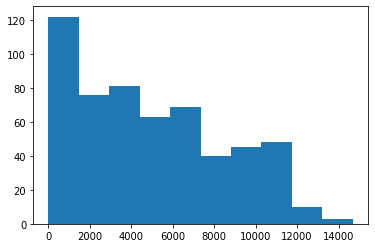

In [141]:
plt.hist(amount)

In [142]:
tmp = cols[numpy.where(amount > 12000)]

In [143]:
tmp[0]

'feat_moments-2-3_combined'

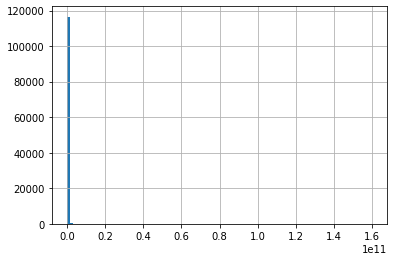

In [144]:
df[tmp[0]].hist(bins=100)

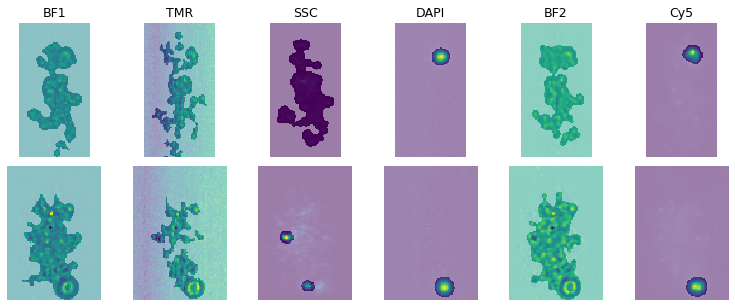

In [145]:
sel1 = df[tmp[0]] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [146]:
tmp[1]

'feat_moments-3-2_combined'

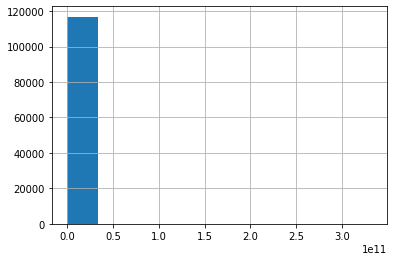

In [147]:
df[tmp[1]].hist()

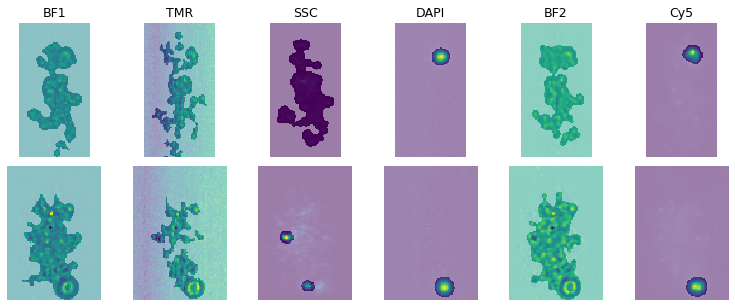

In [148]:
sel1 = df[tmp[1]] > 1e11
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

### Normalized variance

In [149]:
norm_var = df.filter(regex="feat").var() / df.filter(regex="feat").mean()

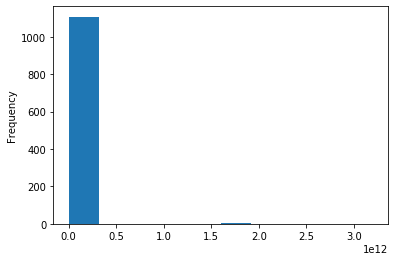

In [150]:
norm_var.plot.hist()

In [151]:
inf_features = norm_var[norm_var.abs() == numpy.inf]

In [152]:
inf_features

Series([], dtype: float64)

In [153]:
for f in inf_features.index:
    s = len(df)
    v = df[f].var()
    while abs(v) == numpy.inf:
        if abs(df[f].min()) > abs(df[f].max()):
            df = df.drop(index=df[f].idxmin())
        else:
            df = df.drop(index=df[f].idxmax())
        v = df[f].var()
    print("Dropped %d rows for %s" % (s-len(df), f))

In [155]:
norm_var[norm_var > 1e12]

feat_moments-3-3_combined    1.121331e+12
feat_moments-3-3_BF1         1.809086e+12
feat_moments-3-3_SSC         3.201105e+12
feat_moments-3-3_BF2         1.656932e+12
dtype: float64

### Isolation forest

In [156]:
from sklearn.ensemble import IsolationForest

In [157]:
iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=5, contamination=0.05)
iso.fit(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.05, n_jobs=5, random_state=0)

In [158]:
pred = iso.predict(
    df.filter(regex="feat")
    .fillna(0)
    .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

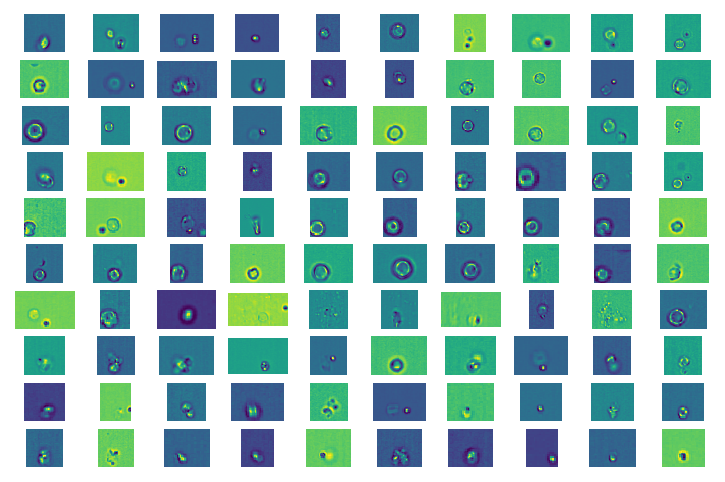

In [165]:
plot_gate_zarr(pred == -1, df, maxn=100)

In [159]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([  5842, 110997]))

In [160]:
norm_var = df[pred == 1].filter(regex="feat").var() / df[pred == 1].filter(regex="feat").mean()

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


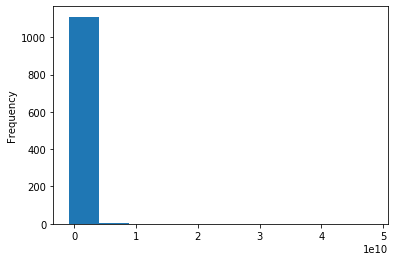

In [161]:
norm_var.plot.hist()

In [163]:
norm_var[norm_var > 1e10]

feat_moments_central-3-3_TMR    4.833584e+10
dtype: float64

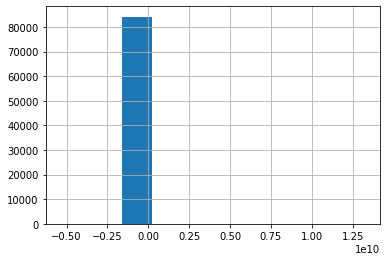

In [166]:
df["feat_moments_central-3-3_TMR"].hist()

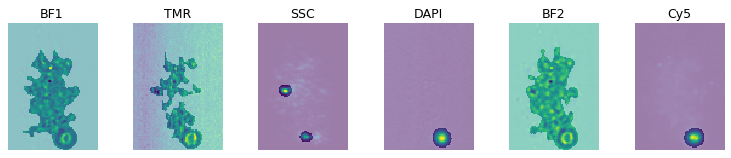

In [167]:
sel1 = df["feat_moments_central-3-3_TMR"] > 1e10
plot_gate_zarr_channels([sel1], df, maxn=3, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

In [168]:
df = df[pred == 1]

# Detecting multiplets that are missed during segmentation

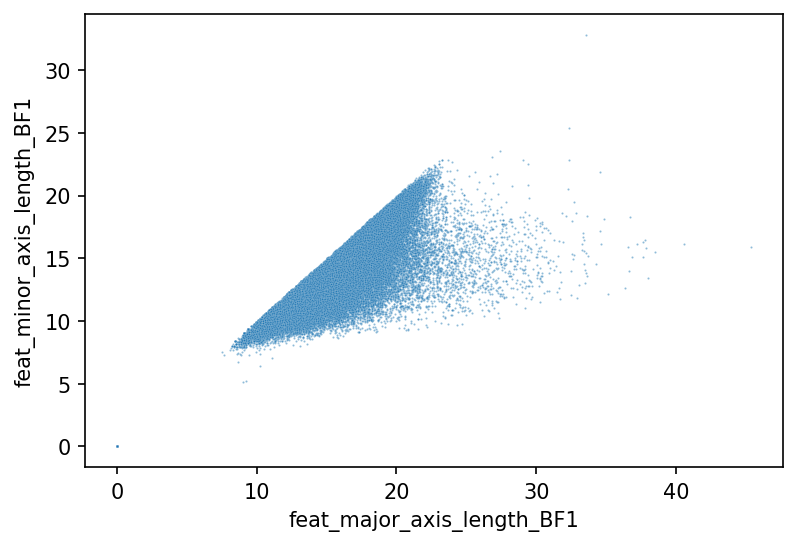

In [169]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_BF1", y="feat_minor_axis_length_BF1", s=1, alpha=0.5, edgecolors="none")

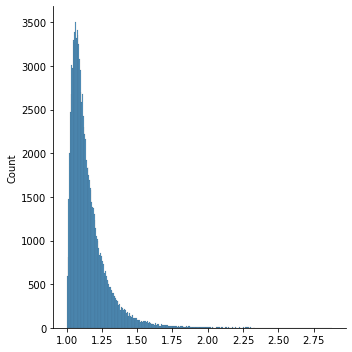

In [170]:
feat_majorminor_ratio = df["feat_major_axis_length_BF1"] / df["feat_minor_axis_length_BF1"]
ax = seaborn.displot(x=feat_majorminor_ratio)

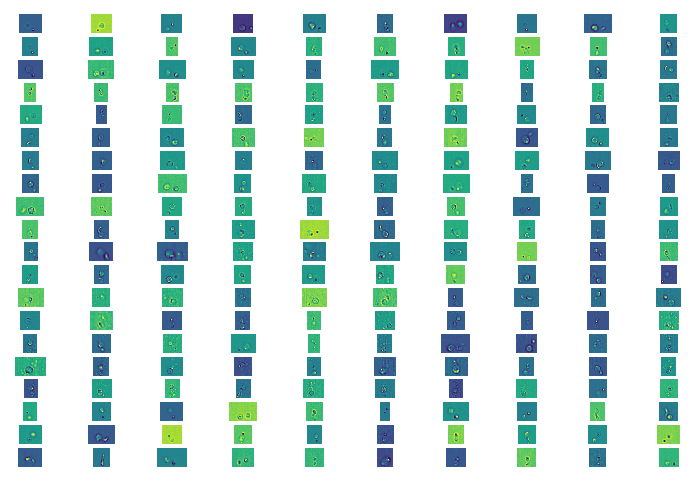

In [171]:
sel1 = feat_majorminor_ratio > 2
plot_gate_zarr(sel1, df)

In [172]:
df = df[~sel1]
df.shape

(110710, 1132)

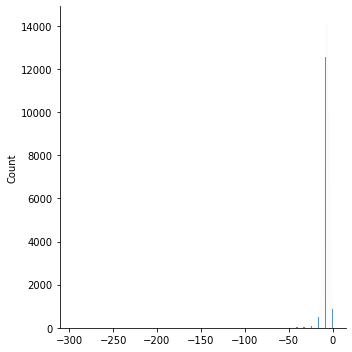

In [173]:
seaborn.displot(data=df["feat_area_BF1"] - df["feat_convex_area_BF1"])

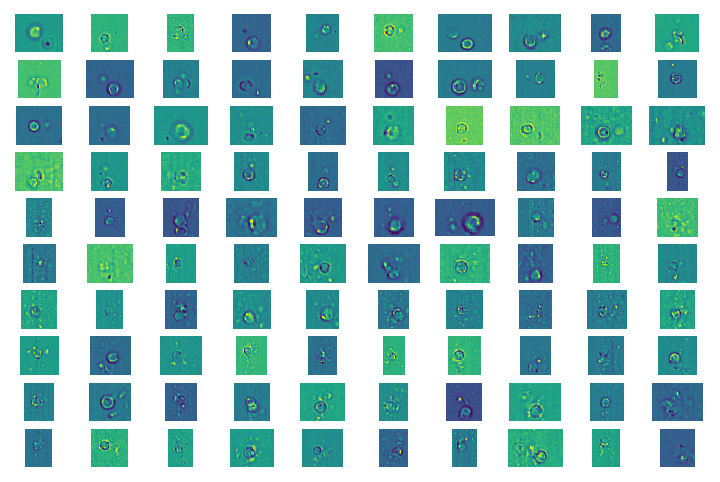

In [176]:
sel1 = (df["feat_area_BF1"] - df["feat_convex_area_BF1"]) < -50
core.plot_gate_zarr(sel1, df, maxn=100)

In [177]:
df = df[~sel1]
df.shape

(110556, 1132)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


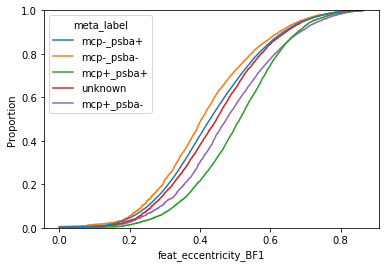

In [178]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_BF1", hue="meta_label")

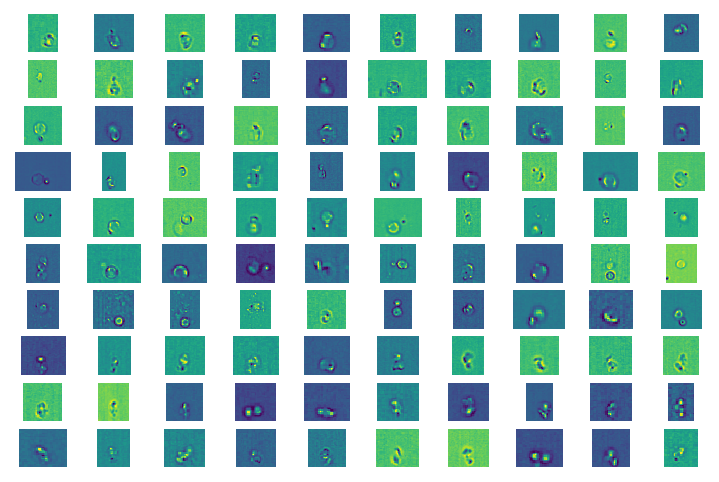

In [181]:
sel1 = df["feat_eccentricity_BF1"] > 0.75
core.plot_gate_zarr(sel1, df, maxn=100)

In [182]:
df = df[~sel1]
df.shape

(108101, 1132)

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


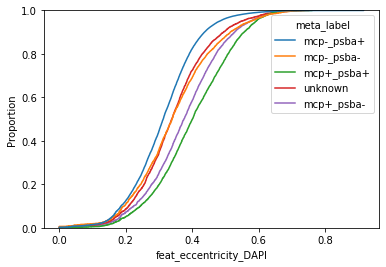

In [183]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_DAPI", hue="meta_label")

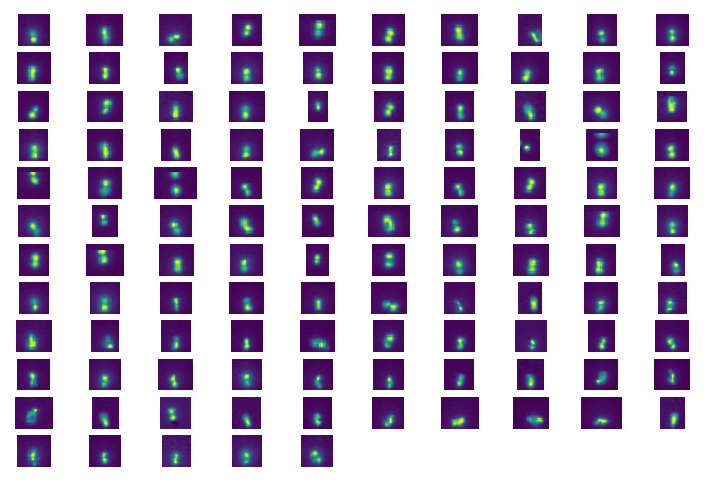

In [185]:
sel1 = df["feat_eccentricity_DAPI"] > 0.7
core.plot_gate_zarr(sel1, df, channel=4)

In [186]:
df = df[~sel1]
df.shape

(107986, 1132)

# Texture features

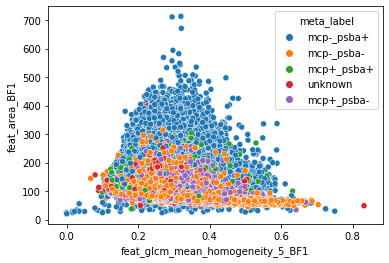

In [70]:
seaborn.scatterplot(data=df, x="feat_glcm_mean_homogeneity_5_BF1", y="feat_area_BF1", hue="meta_label")

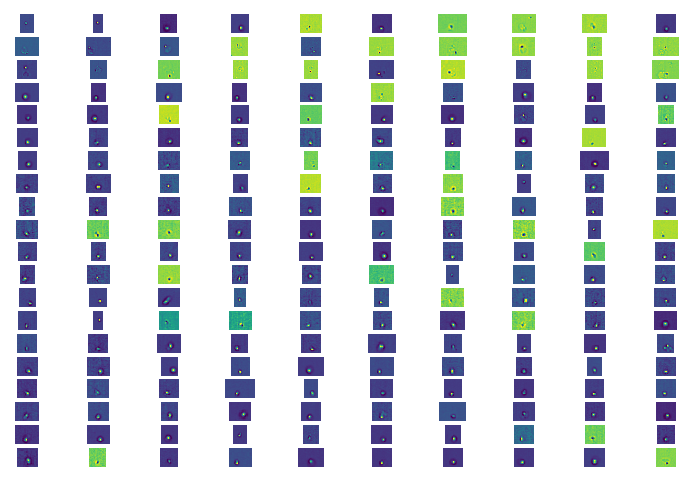

In [192]:
sel1 = df["feat_glcm_mean_homogeneity_5_BF1"] > 0.5
core.plot_gate_zarr(sel1, df)

In [ ]:
df[sel1]["meta_label"].value_counts()

mcp-_psba-    168
mcp+_psba-     46
mcp-_psba+     43
unknown        20
mcp+_psba+      1
Name: meta_label, dtype: int64

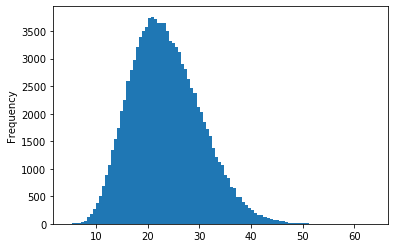

In [195]:
df["feat_glcm_mean_contrast_3_BF1"].plot.hist(bins=100)

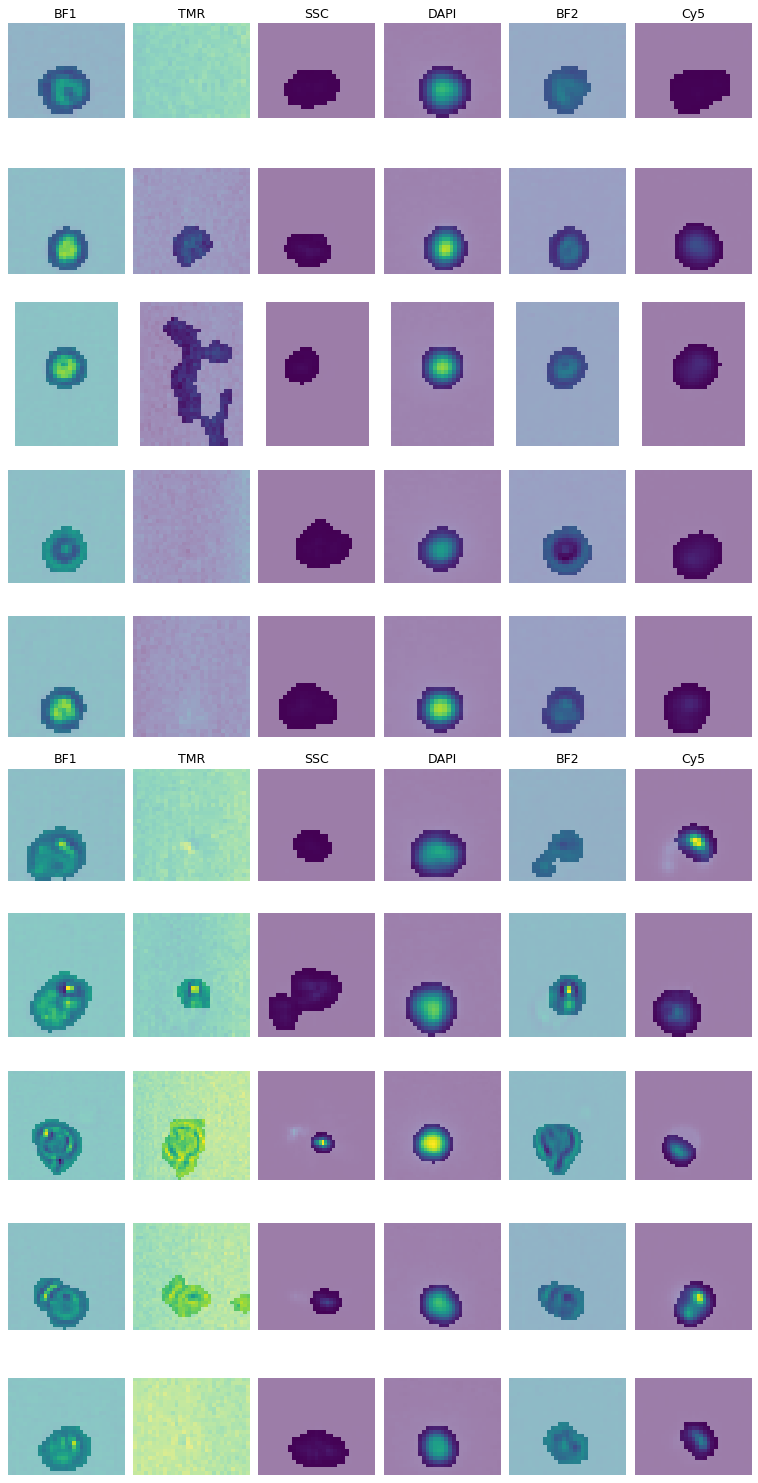

In [197]:
sel1 = df["feat_glcm_mean_contrast_3_BF1"] > 40
sel2 = df["feat_glcm_mean_contrast_3_BF1"] < 10
plot_gate_zarr_channels([sel1, sel2], df, maxn=5, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"])

# Feature correlation

In [198]:
df.filter(regex="feat").var().isna().sum()

0

In [199]:
correlation = df.sample(n=50000).filter(regex="feat.*").corr()

In [90]:
correlation = correlation.drop(columns=df.filter(regex='euler').columns, index=df.filter(regex='euler').columns)

In [92]:
correlation.isna().sum().sum()

0

## Overall feature correlation

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


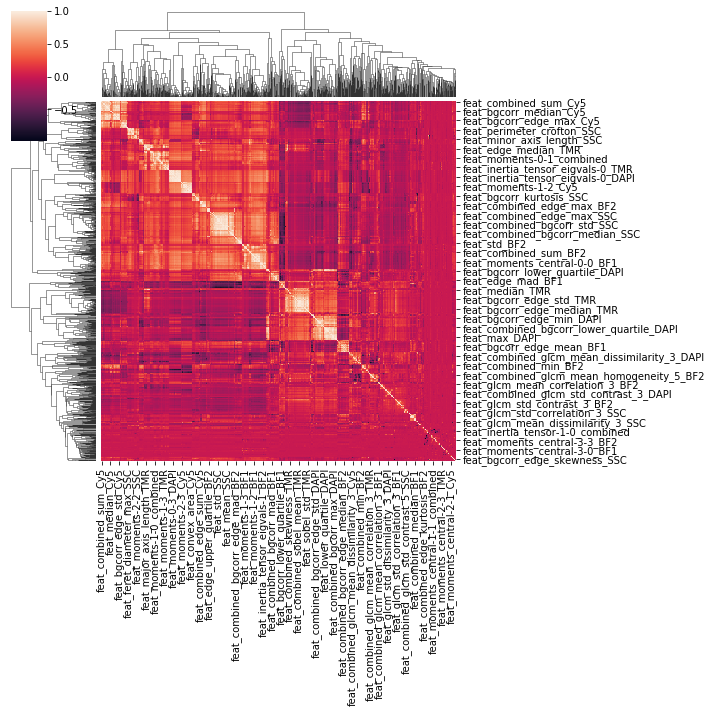

In [93]:
seaborn.clustermap(correlation)

In [94]:
def get_correlated_features(df, cutoff=0.9):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [95]:
correlated_features = get_correlated_features(
    df.filter(regex="feat").drop(columns=df.filter(regex='euler').columns),
    cutoff=0.9
)

In [96]:
correlation2 = df.filter(regex="feat").drop(columns=df.filter(regex='euler').columns).drop(columns=correlated_features).corr()

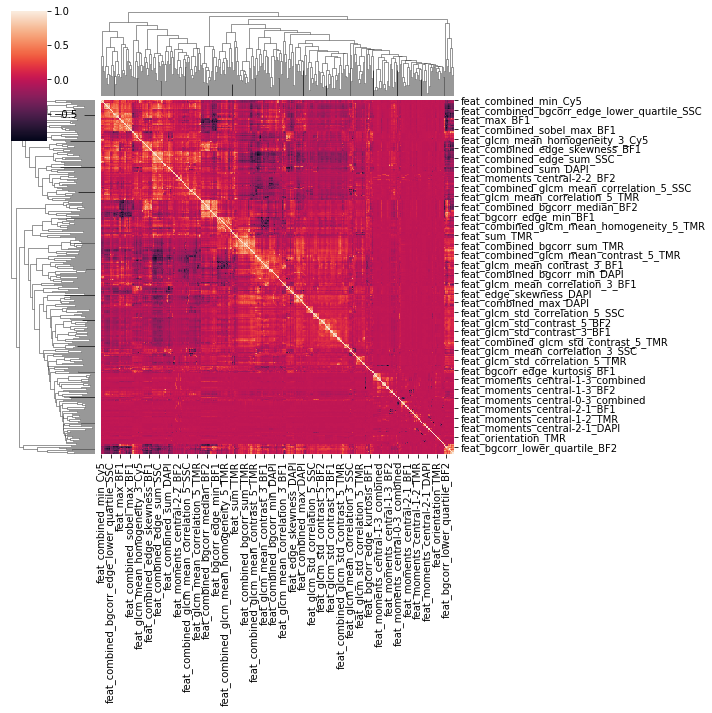

In [97]:
seaborn.clustermap(correlation2)

In [98]:
len(correlated_features)

740

In [113]:
df = df.drop(columns=correlated_features)

In [114]:
df.shape

(122416, 192)

In [115]:
df.filter(regex="feat")

,feat_eccentricity_BF1,feat_euler_number_BF1,feat_orientation_BF1,feat_moments-3-3_BF1,feat_moments_central-2-3_BF1,feat_moments_central-3-2_BF1,feat_moments_central-3-3_BF1,feat_eccentricity_TMR,feat_euler_number_TMR,feat_orientation_TMR,...,feat_combined_glcm_mean_ASM_5_BF2,feat_glcm_mean_energy_5_Cy5,feat_glcm_mean_ASM_3_Cy5,feat_combined_glcm_mean_contrast_3_Cy5,feat_combined_glcm_mean_contrast_5_Cy5,feat_combined_glcm_std_contrast_3_Cy5,feat_combined_glcm_std_contrast_5_Cy5,feat_combined_glcm_mean_correlation_3_Cy5,feat_combined_glcm_mean_correlation_5_Cy5,feat_combined_sobel_max_Cy5
0,0.307837,1.0,0.651998,93449772.0,-60768.521569,13173.953199,238496.961924,0.453763,1.0,-0.345954,...,0.239191,0.142367,0.030724,5.967456,18.690083,0.417160,1.070248,0.484568,-0.346891,0.004976
1,0.274020,1.0,0.957166,83695454.0,-63251.468771,-3857.846663,114927.724862,0.371570,1.0,0.203962,...,0.283877,0.206113,0.078770,4.647929,12.169421,1.387574,1.334711,0.414599,-0.243672,0.006341
2,0.469483,1.0,-1.533550,183680064.0,-8876.145760,-32705.053910,-118148.222486,0.487864,1.0,-1.342362,...,0.167991,0.204180,0.064911,4.361538,8.076923,0.556410,2.139860,0.372890,-0.087956,0.005015
3,0.297177,1.0,0.119677,89196667.0,47443.052655,-2376.408583,43576.093434,0.463001,1.0,0.584667,...,0.821384,0.175339,0.051015,6.237179,13.740909,0.500000,1.168182,0.388660,-0.262454,0.002499
4,0.298682,1.0,-0.816903,254625508.0,79097.001711,-28898.660400,-523231.209085,0.370918,1.0,-1.298421,...,0.170600,0.160561,0.036178,3.355556,9.837278,0.093333,0.417160,0.574196,-0.127696,0.001794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142444,0.535848,1.0,0.572908,93349223.0,-38305.931745,-36228.563812,489860.512436,0.526163,1.0,0.000000,...,0.341670,0.214233,0.074334,10.030220,12.848485,2.381868,2.045455,0.212038,-0.059949,0.000385
142445,0.434164,1.0,-0.467023,76208479.0,-10597.327595,3759.690581,-125905.085605,0.298735,1.0,0.630889,...,0.224031,0.340326,0.271619,10.739796,15.850694,0.846939,1.149306,0.257233,-0.138851,0.000385
142446,0.385408,1.0,0.662577,48146662.0,-12807.388771,-11364.266605,120819.537883,0.375131,1.0,1.551818,...,0.256942,0.319566,0.189380,9.394231,12.213636,1.323718,1.640909,0.141866,-0.102046,0.000418
142448,0.512218,1.0,-0.580645,97567219.0,-40412.469065,51815.017591,-557414.754265,0.513055,1.0,-0.137372,...,0.247561,0.309548,0.184994,7.013736,9.799242,2.453297,3.200758,0.303919,-0.088344,0.000392


In [223]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [224]:
pca = PCA().fit_transform(scale(df.filter(regex="feat").fillna(0)))

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


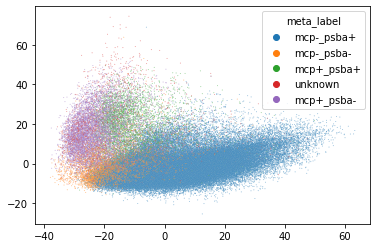

In [227]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none")

In [229]:
import umap

In [228]:
pca = PCA(n_components=0.95).fit_transform(scale(df.filter(regex="feat").fillna(0)))

/scratch/gent/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [231]:
%%time
model = umap.UMAP(densmap=False, random_state=42, metric="cosine")
projection = model.fit_transform(pca)

CPU times: user 4min 32s, sys: 34.9 s, total: 5min 7s
Wall time: 3min 5s


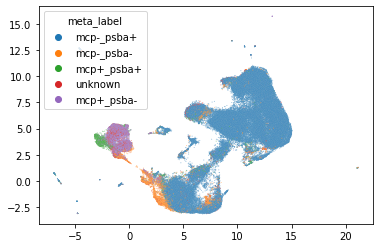

In [232]:
seaborn.scatterplot(x=projection[:, 0], y=projection[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none")

# Export

In [200]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/index.npy", df.index.values)

In [201]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/columns.npy", df.columns.values)